In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats import pearsonr

from easydict import EasyDict as edict
from tqdm import trange
from scipy.io import loadmat

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [3]:
import importlib
import optimization.one_step_opt
importlib.reload(optimization.one_step_opt)

<module 'optimization.one_step_opt' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/optimization/one_step_opt.py'>

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT

from hdf_utils.data_gen import gen_covs, gen_simu_psd
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl
from splines import obt_bsp_basis_Rfn
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt

from penalties.scad_pen import SCAD
from penalties.base_pen import PenaltyBase
from models.logistic_model import LogisticModel
from models.linear_model import LinearModel


<class 'easydict.EasyDict'>


In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Param and data

### load data

In [7]:
# PSD from AD vs Ctrl
dat_AD = loadmat(DATA_ROOT/"87ADs_before_filter1000_PSD.mat")["fmegall"]
dat_AD_add = loadmat(DATA_ROOT/"DK_timecourse_PSD.mat")["FMEGdata"]
dat_AD = np.concatenate([dat_AD, dat_AD_add[np.newaxis]], axis=0)
dat_AD = np.transpose(dat_AD, (1, 2, 0))

dat_ctrl = loadmat(DATA_ROOT/"70Ctrls_before_filter1000_PSD.mat")["fmegall"]
dat_ctrl_add = loadmat(DATA_ROOT/"timecourse_ucsfCONT_group_PSD.mat")["fmegall"]
dat_ctrl = np.concatenate([dat_ctrl, dat_ctrl_add], axis=0)
dat_ctrl = np.transpose(dat_ctrl, (1, 2, 0))

ind_freq = np.linspace(1, 40, 40)
dat_all = np.concatenate([dat_AD, dat_ctrl], axis=-1)
kp_idx = np.log10(dat_all).mean(axis=0).mean(axis=0) > 2
dat_all = dat_all[:, :, kp_idx]
print(dat_all.shape)

res_dat = edict()
res_dat.psd = dat_all
res_dat.ind_freq = ind_freq
save_pkl(DATA_ROOT/"ctrl_vs_AD_nooutlier.pkl", res_dat, is_force=True)

(68, 40, 168)
Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/ctrl_vs_AD_nooutlier.pkl


In [8]:
# 36 dataset
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')                                                                                              
ind_psd = ind_psd_xr.values
ind_freq = ind_psd_xr["frequencies"].values

### Parameters

In [25]:
paras = edict()
paras.seed = 0
paras.npts = 40 # num of pts to evaluate X(s)
paras.d = 10 # num of ROIs
paras.q = 3 # num of other covariates
paras.M = 200 # num of data obs to be genareted
paras.sigma2 = 1 # variance of the error

paras.bsp = edict()
paras.bsp.aknots_raw = np.linspace(0, 1, 20)
paras.bsp.iknots = paras.bsp.aknots_raw[1:-1]
paras.bsp.bknots = np.array([0, 1])
paras.bsp.ord = 4
paras.bsp.x = np.linspace(0, 1, paras.npts)
#paras.bsp.x = np.linspace(0, 1, paras.npts+1)[:-1]
paras.bsp.basis_mat = obt_bsp_basis_Rfn(paras.bsp.x, 
                                        paras.bsp.iknots, 
                                        paras.bsp.bknots, 
                                        paras.bsp.ord)
paras.bsp.N = paras.bsp.basis_mat.shape[1] # num of basis for bsp

### Fns

## Generate simulated data

In [71]:
np.random.seed(paras.seed)
# simulated PSD

simu_psd = np.log10(dat_all.transpose((2, 0, 1)))[:paras.M, :paras.d, :]
simu_psd = gen_simu_psd(paras.M, paras.d, 10)
# simulated covs
types_ = ["int", 2, "c"]
assert len(types_) == paras.q
simu_covs = gen_covs(paras.M, types_)
simu_covs;

In [72]:
# parameters
np.random.seed(paras.seed)
rm_idxs = np.arange(2)
#rm_idxs = np.random.choice(paras.d, 10, replace=False)
Gam_GT = np.random.randn(paras.bsp.N, paras.d)*50
alp_GT = np.array([5, 1, 2])*1
assert len(alp_GT) == paras.q

Gam_GT[:, rm_idxs] = 0

In [73]:
# linear term and Y
beta_mat = paras.bsp.basis_mat @ Gam_GT
beta_mat = np.asarray(beta_mat.T)

#simu_psd = np.log10(np.transpose(ind_psd, (-1, 0, 1)))
int_part = np.sum(beta_mat * simu_psd[:, :, :], axis=1).mean(axis=1)

cov_part = simu_covs @ alp_GT 

# linear term
lin_term = cov_part + int_part
probs = logit_fn(lin_term)
print(f" The percentage of probs>0.5 is {np.mean(probs>0.5)*100:.1f}%.")

# Y 
rvs = np.random.rand(paras.M)
Y = (rvs<probs).astype(float)
Y = lin_term + np.random.randn(paras.M)*np.sqrt(paras.sigma2)

 The percentage of probs>0.5 is 93.5%.


In [74]:
# To torch
X = torch.tensor(simu_psd) # M x d x npts
Z = torch.tensor(simu_covs) # M x q
Y = torch.tensor(Y)


basis_mat = torch.DoubleTensor(paras.bsp.basis_mat) # npts x N


In [75]:
# estimate with linear regression (only for check)
model = LinearModel(Y=Y, X=X, Z=Z, basis_mat=basis_mat, sigma2=paras.sigma2)
model._linear_term_der()
Xt = model.lin_tm_der # Mx(q+dN)
est_theta = svd_inverse(Xt.T @ Xt + 0*torch.eye(Xt.shape[-1]))@Xt.T@Y
#est_theta = torch.inverse(Xt.T @ Xt)@Xt.T@Y

est_alp = est_theta[:paras.q]
est_gam = col_vec2mat_fn(est_theta[paras.q:], nrow=paras.bsp.N)/np.sqrt(paras.bsp.N)
print(est_alp)

Yt1 = Xt@est_theta
(Yt1-lin_term)[:10]

tensor([7.2624, 0.6804, 2.0784])


tensor([-0.1455, -2.1653,  2.3004,  1.4207, -0.0977,  1.4664, -1.0601, -2.3434,
         0.5288, -2.2566])

## Test optimization

In [92]:
np.random.seed(paras.seed)
torch.manual_seed(paras.seed)

alp_init = torch.randn(paras.q)
Gam_init = torch.randn(paras.bsp.N, paras.d) # N x d
theta_init = None
alp_init = torch.tensor(alp_GT) + torch.randn(paras.q)*10
Gam_init = torch.tensor(Gam_GT) + torch.randn(paras.bsp.N, paras.d)*10
theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(paras.bsp.N)])

rhok_init = torch.randn(paras.d*paras.bsp.N)

Rmin = 2*(np.linalg.norm(Gam_GT/np.sqrt(paras.bsp.N), axis=0).sum() + np.abs(alp_GT).sum())
Rmin

802.8232605710607

In [93]:
#model = LogisticModel(Y=Y, X=X, Z=Z, basis_mat=basis_mat)
model = LinearModel(Y=Y, X=X, Z=Z, basis_mat=basis_mat, sigma2=paras.sigma2)
pen = SCAD(lams=3e0, a=2.7, 
          sel_idx=None
          )

max_iter = 200
for ix in trange(max_iter):
    opt = OneStepOpt(Gamk=Gam_init, 
                  rhok=rhok_init, 
                  theta_init=theta_init, 
                  alpha=0.9, beta=1, model=model, penalty=pen, 
                  q=paras.q, NR_eps=1e-5, NR_maxit=100, R=Rmin*0.5)
    #print(opt.theta_init[:paras.q])
    opt()
    #print(opt.Gamk)
    Gam_init = opt.Gamk
    rhok_init = opt.rhok
    theta_init = opt.thetak

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 420.94it/s]


In [94]:
opt.thetak[:paras.q]

tensor([6.3198, 0.8271, 1.9100])

In [95]:
opt.Gamk.norm(dim=0)

tensor([  0.0000,   0.0000, 176.2381, 293.9172, 240.6457, 229.7731, 199.8425,
        177.7957, 251.5712, 173.9696])

In [96]:
np.linalg.norm(Gam_GT, axis=0)

array([  0.        ,   0.        , 198.90526615, 305.57298593,
       246.55160588, 229.6490149 , 213.21863098, 204.35053708,
       262.00288114, 185.01318873])

In [97]:
diff = opt.Gamk - col_vec2mat_fn(opt.thetak[paras.q:], nrow=paras.bsp.N)*np.sqrt(paras.bsp.N)
torch.norm(diff)/torch.norm(opt.Gamk)

tensor(0.0001)

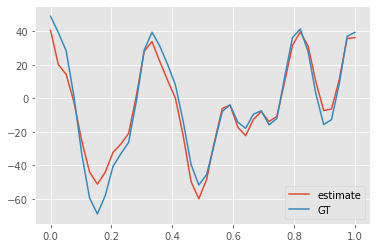

In [98]:
est_beta_mat = (basis_mat @opt.Gamk).T.numpy()
ix = 2
plt.plot(paras.bsp.x, est_beta_mat[ix, :], label="estimate")
plt.plot(paras.bsp.x, beta_mat[ix, :], label="GT")
plt.legend()

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


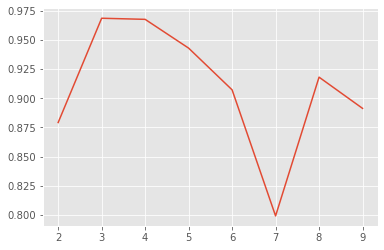

In [55]:
corrs_res = []
for ix in range(paras.d):
    corr_res = pearsonr(est_beta_mat[ix, :], beta_mat[ix, :])
    corrs_res.append(corr_res)
corrs_res = np.array(corrs_res)

plt.plot(corrs_res[:, 0])